# Make requests to the Best Buy API

https://bestbuyapis.github.io/api-documentation/

https://developer.bestbuy.com/secure/dashboard

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import requests
session = requests.Session()

ModuleNotFoundError: No module named 'requests'

In [ ]:
# Load the API key
with open("./.bestbuy_api_key.txt") as fi:
    api_key = fi.read().split(": ", 1)[-1].strip()

In [ ]:
url = f"https://api.bestbuy.com/v1/products(search=flat&search=screen&search=tv)?format=json&show=sku,name,salePrice&apiKey={api_key}"
url = f"https://api.bestbuy.com/v1/products(search=flat%20screen%20tv)?format=json&page=1&pageSize=100&apiKey={api_key}"
url = f'https://api.bestbuy.com/v1/products(categoryPath.name="All%20Flat-Panel%20TVs")?format=json&show=sku,name,salePrice&apiKey={api_key}'

# Search for flat screen 4K TVs

In [3]:
def assemble_request(search_term, **kwargs):   
    s = ""
    for key, value in params.items():
        s += f"&{key}={value}"
    url = f"https://api.bestbuy.com/v1/products((search={search_term.replace(' ', '%20')})&(categoryPath.id=abcat0101000))?apiKey={api_key}&format=json" + s
    return url

In [4]:
fields = 'name,regularPrice,screenSizeIn,sku'
products = pd.DataFrame(columns=fields.split(','))
search_term = "4K"
for page_num in range(1, 20):
    params = {'page': page_num,
              'pageSize': 50,
              'show': fields}
    url = assemble_request(search_term, **params)

    # Make the request
    r = session.get(url)
    assert r.status_code == 200, f"Bad response: {r.status_code}"
    tmp = pd.DataFrame(r.json()['products'])
    print(f"Found {len(tmp)} product results")
    if not len(tmp):
        break
    products = pd.concat([products, tmp])
    time.sleep(5)

# Remove duplicates and set index to the SKU number
products.drop_duplicates(subset=['sku'], inplace=True)
products.set_index('sku', inplace=True)

Found 50 product results
Found 50 product results
Found 50 product results
Found 25 product results
Found 0 product results


In [45]:
products.to_pickle("4k_tv_prices.pickle")

In [3]:
products = pd.read_pickle("4k_tv_prices.pickle")

In [5]:
import numpy as np

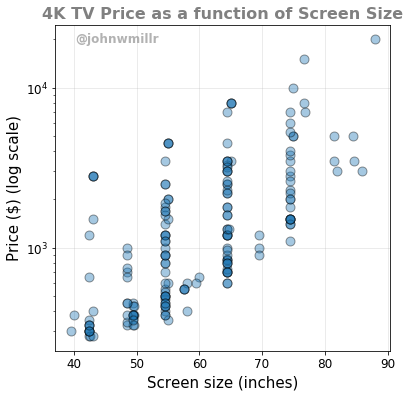

In [37]:
plot_dict = {'style': 'o', 'ms': 9, 'alpha': 0.4, 'fontsize': 12, 'figsize': (6, 6), 'markeredgecolor': 'k', 'legend': False}
products.plot(y='regularPrice', x='screenSizeIn', logy=True, **plot_dict)
plt.xlabel("Screen size (inches)", fontsize=15)
plt.ylabel("Price ($) (log scale)", fontsize=15)
plt.title("4K TV Price as a function of Screen Size", fontsize=16, color="gray", weight="heavy", loc='center')
plt.grid(True, axis='both', alpha=0.3)
plt.text(40.3, 19.2e3, "@johnwmillr", ha="left", fontsize=12, color='gray', weight='heavy', alpha=0.6)
plt.show()
# plt.savefig("./price_vs_size_logy.png", dpi=300, bbox_inches='tight')

# Fit an exponential curve to the plot

In [6]:
from scipy.optimize import curve_fit

In [9]:
def exponenial_func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [20]:
x = products['screenSizeIn']
y = products['regularPrice']
popt, pcov = curve_fit(exponenial_func, x, y, p0=(1, 1e-6, 1))

In [27]:
xx = np.linspace(1, 100, 500)
yy = exponenial_func(xx, *popt)

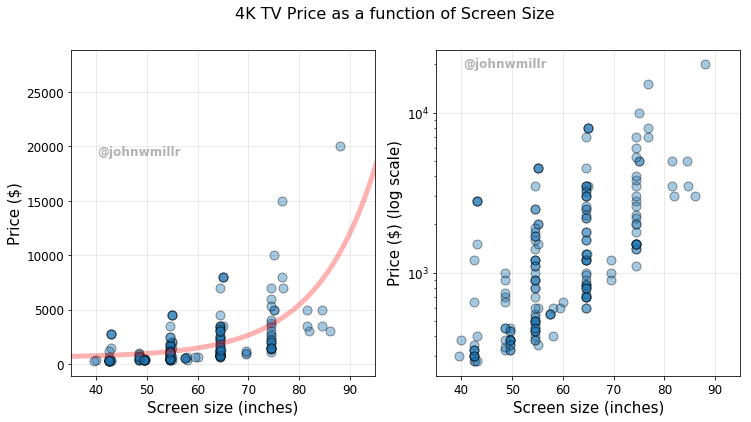

In [33]:
plot_dict = {'style': 'o', 'ms': 9, 'alpha': 0.4, 'fontsize': 12, 'figsize': (12, 6), 'markeredgecolor': 'k', 'legend': False}

logs = [False, True]
fig, axs = plt.subplots(ncols=2)
for ax, logy in zip(axs, logs):
    products.plot(y='regularPrice', x='screenSizeIn', logy=logy, **plot_dict, ax=ax, sharex=True)
    if not logy:
        ax.plot(xx, yy, 'r', lw=5, alpha=0.3)
    ax.set_xlim([35, 95])
    ax.set_xlabel("Screen size (inches)", fontsize=15)
    ax.set_ylabel(f"Price ($){' (log scale)' if logy else ''}", fontsize=15)
    ax.grid(True, axis='both', alpha=0.3)
    ax.text(40.3, 19.2e3, "@johnwmillr", ha="left", fontsize=12, color='gray', weight='heavy', alpha=0.6)
# plt.suptitle("4K TV Price as a function of Screen Size", fontsize=16, color="gray", weight="heavy", loc='center')    
plt.suptitle("4K TV Price as a function of Screen Size", fontsize=16)
plt.show()
# plt.savefig("./price_vs_size_logy.png", dpi=300, bbox_inches='tight')

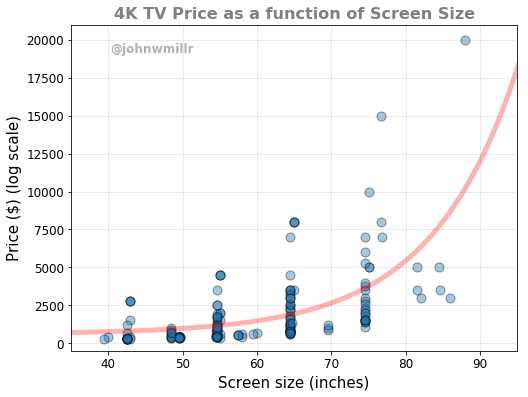

In [49]:
plot_dict = {'style': 'o', 'ms': 9, 'alpha': 0.4, 'fontsize': 12, 'figsize': (8, 6), 'markeredgecolor': 'k', 'legend': False}
products.plot(y='regularPrice', x='screenSizeIn', logy=False, **plot_dict)
plt.plot(xx, yy, 'r', lw=5, alpha=0.3)

plt.xlim([35, 95])
plt.ylim([-500, 21e3])
plt.xlabel("Screen size (inches)", fontsize=15)
plt.ylabel("Price ($) (log scale)", fontsize=15)
plt.title("4K TV Price as a function of Screen Size", fontsize=16, color="gray", weight="heavy", loc='center')
plt.grid(True, axis='both', alpha=0.3)
plt.text(40.3, 19.2e3, "@johnwmillr", ha="left", fontsize=12, color='gray', weight='heavy', alpha=0.6)
plt.show()
# plt.savefig("./price_vs_size_logy.png", dpi=300, bbox_inches='tight')